In [10]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #keras is what we need for LSTM
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [18]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%m/%Y')

In [19]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [20]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [21]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [22]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [23]:
 # fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [24]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [26]:
 # load dataset
series = read_csv('theft_data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-70], supervised_values[-70:]
        #train with first 1/3 of data (first 140 points)
        #test with last 1/3 (last 70 points)
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Month=1, Predicted=3003.689599, Expected=2705.000000
Month=2, Predicted=2659.976890, Expected=2381.000000
Month=3, Predicted=2318.299592, Expected=2217.000000
Month=4, Predicted=2181.835377, Expected=2225.000000
Month=5, Predicted=2229.265204, Expected=1978.000000
Month=6, Predicted=1938.431811, Expected=1507.000000
Month=7, Predicted=1415.886036, Expected=1873.000000
Month=8, Predicted=1941.762332, Expected=1987.000000
Month=9, Predicted=2029.199715, Expected=2532.000000
Month=10, Predicted=2667.562967, Expected=2460.000000
Month=11, Predicted=2481.659327, Expected=3006.000000
Month=12, Predicted=3140.825239, Expected=3089.000000
Month=13, Predicted=3140.631820, Expected=2732.000000
Month=14, Predicted=2687.139588, Expected=2454.000000
Month=15, Predicted=2402.406331, Expected=2281.000000
Month=16, Predicted=2245.587359, Expected=2002.000000
Month=17, Predicted=1948.077744, Expected=1853.000000
Month=18, Predicted=1823.377089, Expected=1654.000000
Month=19, Predicted=1617.081600, Expe

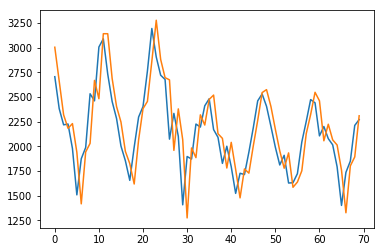

In [27]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 500, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-70:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-70:])
pyplot.plot(predictions)
pyplot.show()

[3003.6895993947983, 2659.9768904447556, 2318.299591779709, 2181.8353768587112, 2229.2652035951614, 1938.4318107366562, 1415.8860355615616, 1941.7623323202133, 2029.1997154951096, 2667.5629667043686, 2481.6593265533447, 3140.8252388238907, 3140.631820201874, 2687.1395877599716, 2402.4063314199448, 2245.587359070778, 1948.0777444839478, 1823.3770886659622, 1617.0815998315811, 2064.3474251031876, 2380.9755758047104, 2454.5999133586884, 2861.6865022182465, 3277.3792003393173, 2880.388563156128, 2695.432620882988, 2673.1025351285934, 1958.1597508192062, 2378.6338645219803, 2066.534122109413, 1273.2183116674423, 1982.6284393072128, 1884.2841807603836, 2318.288989365101, 2214.9174062013626, 2475.020661830902, 2518.545189499855, 2126.899852156639, 2079.693349480629, 1779.1658163070679, 2039.3107348680496, 1765.1736878156662, 1476.5385197401047, 1769.6556063890457, 1727.399584054947, 2003.6520037651062, 2261.7317349910736, 2543.7346777915955, 2573.930323600769, 2402.71553337574, 2172.197047829

<function matplotlib.pyplot.show(*args, **kw)>

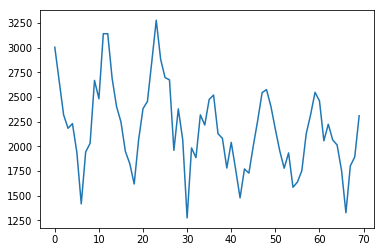

In [36]:
print(predictions)
pyplot.plot(predictions)
pyplot.show

In [31]:
print(raw_values[-70:])

[2705 2381 2217 2225 1978 1507 1873 1987 2532 2460 3006 3089 2732 2454
 2281 2002 1853 1654 1991 2296 2402 2763 3194 2905 2720 2677 2072 2333
 2101 1406 1896 1870 2225 2194 2410 2481 2169 2090 1826 2000 1792 1522
 1726 1713 1940 2188 2460 2530 2405 2201 1990 1810 1908 1627 1630 1722
 2043 2251 2473 2440 2105 2200 2077 2014 1792 1400 1735 1849 2211 2270]
